In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'malicious-and-benign-websites:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F8095%2F26462%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240627%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240627T090202Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D57627f2f1a514218fce306db677aceb228eb6c3bb1518bcd01e687aeeece5e38929e93c6d817d230f7ac6b2099edd83b29182b614e8915f4eb410b64f7049e56f9a8630537a994f4373f671b347d636d9232b711ed74e976130aca340206364b95fa4a28bcfc0b2642450bc09219355950c19e829114ea24a78b680b1f44d193dfaac609eb0603344eaa37b764226d847fff9d5f68d27bb3984c57400eb2e49b400fec025e41c395edf172cabbe96ae0ad6d811a074701908b6d6971c30d4883c25e5f0744ed3d0404f12df4dc30a2e15e9a4d1e1c0f246c056d8821b4448092cc4a48b94159b749a3532dd78a784e3456ed8a95f5fa020cbf7d005ce3b40dd4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 48762 bytes downloaded
Downloaded and uncompressed: malicious-and-benign-websites
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/malicious-and-benign-websites/dataset.csv


In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/kaggle/input/malicious-and-benign-websites/dataset.csv')

# Assuming 'Type' column is the target variable and removing non-predictive columns
X = df.drop(['Type'], axis=1)
y = df['Type']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:
# Basic data exploration
print(df.head())
print(df.info())
print(df.describe())

# Check for missing values
print(df.isnull().sum())

       URL  URL_LENGTH  NUMBER_SPECIAL_CHARACTERS     CHARSET  \
0   M0_109          16                          7  iso-8859-1   
1  B0_2314          16                          6       UTF-8   
2   B0_911          16                          6    us-ascii   
3   B0_113          17                          6  ISO-8859-1   
4   B0_403          17                          6       UTF-8   

                  SERVER  CONTENT_LENGTH WHOIS_COUNTRY WHOIS_STATEPRO  \
0                  nginx           263.0           NaN            NaN   
1          Apache/2.4.10         15087.0           NaN            NaN   
2  Microsoft-HTTPAPI/2.0           324.0           NaN            NaN   
3                  nginx           162.0            US             AK   
4                    NaN        124140.0            US             TX   

      WHOIS_REGDATE WHOIS_UPDATED_DATE  ...  DIST_REMOTE_TCP_PORT  REMOTE_IPS  \
0  10/10/2015 18:21                NaN  ...                     0           2   
1       

In [27]:
# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


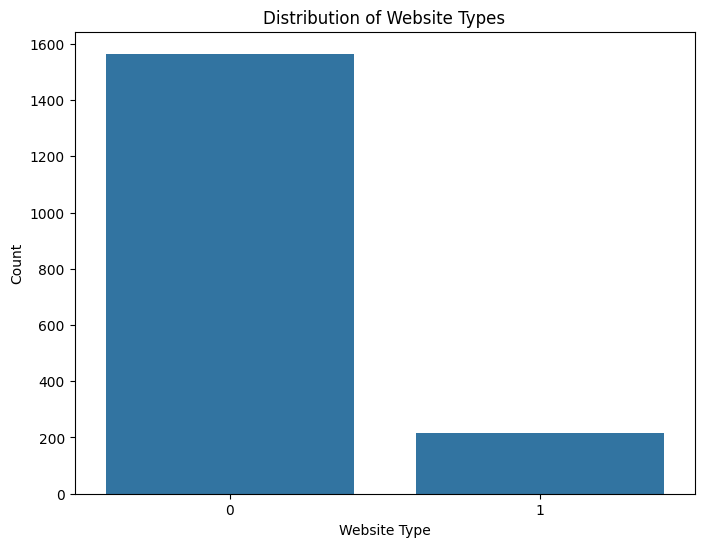

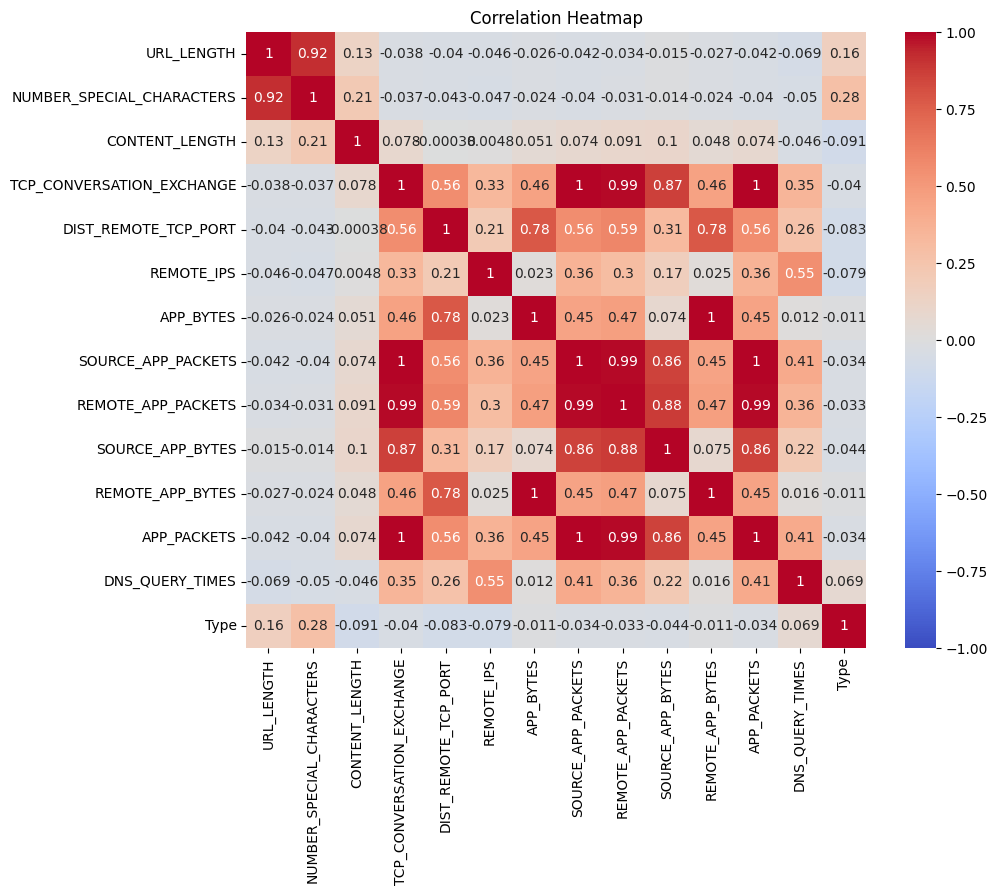

In [29]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Type', data=df)
plt.title('Distribution of Website Types')
plt.xlabel('Website Type')
plt.ylabel('Count')
plt.show()
# Filter out non-numeric columns
numeric_columns = df.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_columns.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()


In [30]:
# Define models to evaluate
models = [
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
    ('Logistic Regression', LogisticRegression(random_state=42))
]

# Evaluate each model in turn
results = []
names = []
for name, model in models:
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    results.append(cv_scores)
    names.append(name)
    print(f'{name}: Mean Accuracy: {cv_scores.mean()}, Std: {cv_scores.std()}')


Random Forest: Mean Accuracy: 0.9613738571781566, Std: 0.012364220795358361
Gradient Boosting: Mean Accuracy: 0.9613689152458612, Std: 0.01388496189097079
Logistic Regression: Mean Accuracy: 0.9557598220904373, Std: 0.011439965913364845


In [36]:
# Select the best model based on mean accuracy
best_model_index = np.argmax([scores.mean() for scores in results])
best_model_name = names[best_model_index]
best_model = models[best_model_index][1]

# Train the best model on the full training set
pipeline_best = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', best_model)
])

pipeline_best.fit(X_train, y_train)

# Predictions on the test set
y_pred = pipeline_best.predict(X_test)

# Print classification report and confusion matrix
print(f'Best Model: {best_model_name}')
print(classification_report(y_test, y_pred))
print(f'Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}')


Best Model: Random Forest
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       306
           1       1.00      0.65      0.79        51

    accuracy                           0.95       357
   macro avg       0.97      0.82      0.88       357
weighted avg       0.95      0.95      0.94       357

Confusion Matrix:
[[306   0]
 [ 18  33]]


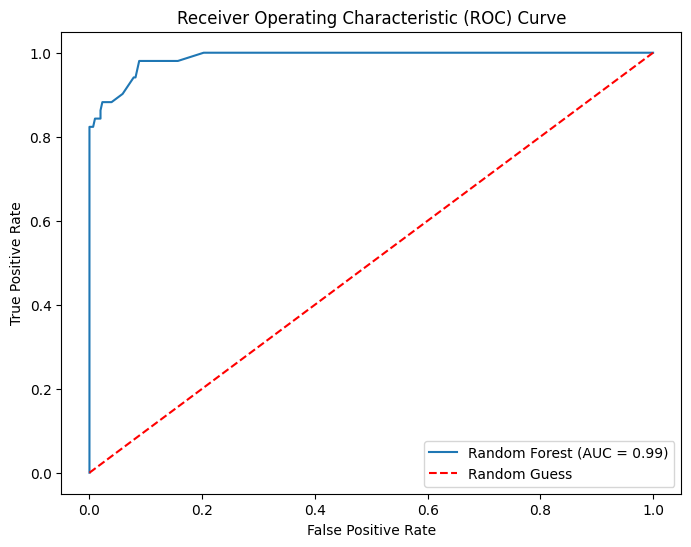

In [37]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
if best_model_name == 'Random Forest':
    y_pred_proba = pipeline_best.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{best_model_name} (AUC = {auc_score:.2f})')
else:
    print(f'{best_model_name} does not have predict_proba')

plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

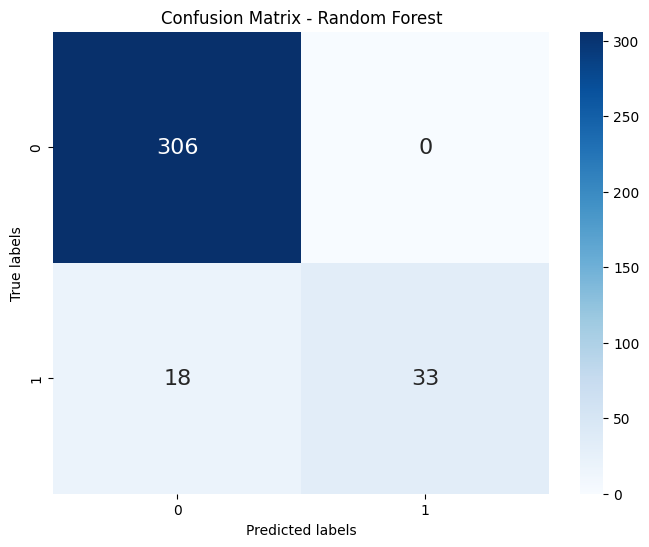

In [38]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', annot_kws={'size': 16})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Random Forest')
plt.show()